In [ ]:
!pip install optuna
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.7 MB/s eta 0:00:00


## Downloading dataset

We can download PNG images from the specified page using helper functions provided by the `torchvision` and `tarfile` libraries.

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

100%|██████████| 135107811/135107811 [00:03<00:00, 41727659.59it/s]


['test', 'train']
['automobile', 'horse', 'dog', 'frog', 'cat', 'truck', 'bird', 'airplane', 'deer', 'ship']


We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Consider exploring a few folders, one from the training set and another from the test set. For practice, you could confirm that each class contains an equal number of images, with 5000 in the training set and 1000 in the test set.

Consider a representative item from the training dataset. Every item comprises an image tensor and an associated label within a tuple. Given that the dataset comprises 32x32-pixel color images with three channels (representing RGB), each image tensor conforms to the shape of (3, 32, 32).

In [ ]:
img, label = dataset[0]
print(img.shape, label)
print(dataset.classes)

torch.Size([3, 32, 32]) 0
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


When building machine learning models, it's common to divide the dataset into three parts:

1. **Training Set**: Used for model training and weight adjustments.
2. **Validation Set**: Assesses the model during training and helps fine-tune parameters.
3. **Test Set**: Compares models and determines final accuracy.

Since we lack a predefined validation set, we'll reserve a small portion (e.g., 5000 images) from the training set using PyTorch's `random_split` method. Setting a seed ensures consistent validation set creation.

In [ ]:
torch.manual_seed(1990)
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print(f'Train dataset size: {len(train_ds)}, Train dataset size: {len(val_ds)}')


batch_size=128
def data_loader(batch_size):
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
    return train_dl,val_dl
train_dl,val_dl = data_loader(batch_size)

Train dataset size: 45000, Train dataset size: 5000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Convolutional layers offer several advantages when processing image data:

1. **Parameter Efficiency**: These layers use a small set of parameters (the kernel) to compute outputs for the entire image, resulting in significantly fewer parameters compared to fully connected layers.
2. **Sparse Connections**: Each output element in a layer depends on only a few input elements, enhancing the efficiency of forward and backward passes.
3. **Parameter Sharing and Spatial Invariance**: Kernels learn features from one part of an image and can detect similar patterns in different parts of other images.

Additionally, we'll utilize max-pooling layers to progressively reduce the height and width of output tensors from each convolutional layer.



This code defines a base class `ImageClassificationBase` for image classification models using PyTorch. The class includes methods commonly used during the training and evaluation process:

1. **`training_step(batch)`**: This method takes a batch of training data (`images` and `labels`) as input, generates predictions using the model (`self(images)`), calculates the loss using cross-entropy loss (`F.cross_entropy`), and returns the loss.

2. **`validation_step(batch)`**: Similar to `training_step`, this method takes a batch of validation data (`images` and `labels`), generates predictions, calculates the loss, and computes the accuracy using the `accuracy` function defined later.

3. **`validation_epoch_end(outputs)`**: This method takes a list of outputs from `validation_step` across all batches in a validation epoch. It combines the losses and accuracies from each batch to calculate the average validation loss and accuracy for the epoch.

4. **`epoch_end(epoch, result)`**: After each training epoch, this method is called to print the training loss, validation loss, and validation accuracy for that epoch.

5. **`accuracy(outputs, labels)`**: This is a helper function used to calculate the accuracy given model predictions (`outputs`) and ground truth labels (`labels`). It calculates the accuracy as the ratio of correctly predicted labels to the total number of labels in the batch.

Overall, this base class provides a structured approach for training and evaluating image classification models, handling training steps, validation steps, and epoch-level summaries.

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0446,  0.0579,  0.0104,  0.0215,  0.0100, -0.0424, -0.0306,  0.0280,
        -0.0424,  0.0283], grad_fn=<SelectBackward0>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7266, val_loss: 1.3800, val_acc: 0.4706
Epoch [1], train_loss: 1.2386, val_loss: 1.0994, val_acc: 0.5885
Epoch [2], train_loss: 0.9700, val_loss: 0.8769, val_acc: 0.6837
Epoch [3], train_loss: 0.7864, val_loss: 0.7567, val_acc: 0.7329
Epoch [4], train_loss: 0.6469, val_loss: 0.7220, val_acc: 0.7519
Epoch [5], train_loss: 0.5423, val_loss: 0.6417, val_acc: 0.7690
Epoch [6], train_loss: 0.4503, val_loss: 0.6611, val_acc: 0.7782
Epoch [7], train_loss: 0.3694, val_loss: 0.6799, val_acc: 0.7770
Epoch [8], train_loss: 0.2961, val_loss: 0.7180, val_acc: 0.7773
Epoch [9], train_loss: 0.2293, val_loss: 0.8626, val_acc: 0.7637


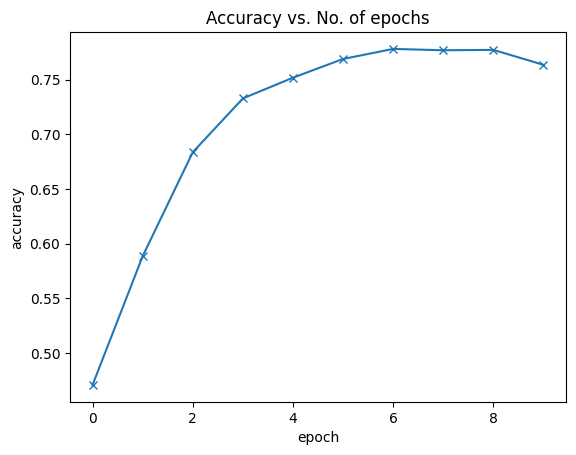

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)